In [0]:
#danaderp May6'19
#Prediction For Main Issues Data Set

In [0]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

/scratch/danaderp/.conda/envs/drmccr_conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [0]:
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [0]:
from datasets.read_data import Dynamic_Dataset,Processing_Dataset
from vectorize_sentence import Embeddings

In [0]:
path = "datasets/augmented_dataset/"
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [0]:
dataset = Dynamic_Dataset(ground_truth, path)

In [0]:
test, train = process_unit.get_test_and_training(ground_truth)

In [0]:
print(len(test))
print(len(train))
print(test[0])
print(train[0])

11612
104510
('(1,0)', 'Heap-based buffer overflow in the yy_get_next_buffer function in Flex before 2.6.1 might allow context-dependent attackers to cause a denial of service or possibly execute arbitrary code via vectors involving num_to_read.')
('(1,0)', 'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/')


In [0]:
#Train/Test split verification
#for elem in test:
#    print(elem[0])

In [0]:
#Preprocesing Corpora
embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [0]:
print(len(pre_corpora_train))
print(len(pre_corpora_test))

103873
11542


In [0]:
embed_path = 'datasets/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [0]:
corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_test]#vectorization

In [0]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output
#target_train

In [0]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [0]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 618


In [0]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [0]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Mix. Sentence # words:",min_len_sentences)

Mix. Sentence # words: 1


In [0]:
embed_size = np.size(corpora_train[0][0])

In [0]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [0]:
input_sh

(618, 100, 1)

In [0]:
#baseline_model = Sequential()
gram_input = Input(shape = input_sh)

In [0]:
# 1st Convolutional Layer Convolutional Layer (7-gram)
conv_1_layer = Conv2D(filters=32, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,embeddigs_cols), padding='valid')(gram_input)
conv_1_layer.shape

TensorShape([None, 612, 1, 32])

In [0]:
# Max Pooling 
max_1_pooling = MaxPooling2D(pool_size=((max_len_sentences-7+1),1), strides=None, padding='valid')(conv_1_layer)
max_1_pooling.shape

TensorShape([None, 1, 1, 32])

In [0]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_1_pooling)
fully_connected_1_gram.shape

TensorShape([None, 32])

In [0]:
fully_connected_1_gram = Reshape((32, 1, 1))(fully_connected_1_gram)
fully_connected_1_gram.shape

TensorShape([None, 32, 1, 1])

In [0]:
# 2nd Convolutional Layer (5-gram)
conv_2_layer = Conv2D(filters=64, kernel_size=(5,1), activation='relu', 
                      padding='valid')(fully_connected_1_gram)
conv_2_layer.shape

TensorShape([None, 28, 1, 64])

In [0]:
max_2_pooling = MaxPooling2D(pool_size=((32-5+1),1), strides=None, padding='valid')(conv_2_layer)
max_2_pooling.shape

TensorShape([None, 1, 1, 64])

In [0]:
# Fully Connected layer
fully_connected_2_gram = Flatten()(max_2_pooling)
fully_connected_2_gram.shape

TensorShape([None, 64])

In [0]:
fully_connected_2_gram = Reshape((64, 1, 1))(fully_connected_2_gram)
fully_connected_2_gram.shape

TensorShape([None, 64, 1, 1])

In [0]:
# 3rd Convolutional Layer (3-gram)
conv_3_layer =  Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                      padding='valid')(fully_connected_2_gram)
conv_3_layer.shape

TensorShape([None, 62, 1, 128])

In [0]:
# 4th Convolutional Layer (3-gram)
conv_4_layer = Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_3_layer)
conv_4_layer.shape

TensorShape([None, 60, 1, 128])

In [0]:
# 5th Convolutional Layer (3-gram)
conv_5_layer = Conv2D(filters=64, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_4_layer)
conv_5_layer.shape

TensorShape([None, 58, 1, 64])

In [0]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(58,1), strides=None, padding='valid')(conv_5_layer)
max_5_pooling.shape

TensorShape([None, 1, 1, 64])

In [0]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)
fully_connected.shape

TensorShape([None, 64])

In [0]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(32, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.2)(deep_dense_1_layer) # <-------- [HyperParameter]

In [0]:
deep_dense_1_layer.shape

TensorShape([None, 32])

In [0]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(32, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.2)(deep_dense_2_layer) # <-------- [HyperParameter]

In [0]:
deep_dense_2_layer.shape

TensorShape([None, 32])

In [0]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(16, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.2)(deep_dense_3_layer) # <-------- [HyperParameter]

In [0]:
deep_dense_3_layer.shape

TensorShape([None, 16])

In [0]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)

In [0]:
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [0]:
print(criticality_network.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 618, 100, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 612, 1, 32)        22432     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 1, 1)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 1, 64)         384       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 64)          0     

In [0]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

In [0]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [0]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), 'alex-res-adapted-003_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), 'alex-res-adapted-003_temp_corpora_test_x.dat')

In [0]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [0]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [0]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [0]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [0]:
corpora_train_x.shape

(103873, 618, 100, 1)

In [0]:
target_train_y.shape

(103873, 2)

In [0]:
corpora_test_x.shape

(11542, 618, 100, 1)

In [0]:
target_test_y.shape

(11542, 2)

In [0]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#CheckPoints
#csv_logger = CSVLogger(system+'_training.log')
filepath = "alex-adapted-res-003/best_model.hdf5"

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [0]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=2000, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Train on 83098 samples, validate on 20775 samples
Epoch 1/2000
83072/83098 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9188
Epoch 00001: val_accuracy improved from -inf to 0.99528, saving model to alex-adapted-res-003/best_model.hdf5
83098/83098 [==============================] - 164s 2ms/sample - loss: 0.2264 - accuracy: 0.9188 - val_loss: 0.0146 - val_accuracy: 0.9953
Epoch 2/2000
83072/83098 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9535
Epoch 00002: val_accuracy did not improve from 0.99528
83098/83098 [==============================] - 163s 2ms/sample - loss: 0.1386 - accuracy: 0.9535 - val_loss: 0.0358 - val_accuracy: 0.9884
Epoch 3/2000
83040/83098 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9583
Epoch 00003: val_accuracy improved from 0.99528 to 0.99721, saving model to alex-adapted-res-003/best_model.hdf5
83098/83098 [==============================] - 162s 2ms/sample - loss: 0.1249 - accuracy

83072/83098 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9934
Epoch 00054: val_accuracy did not improve from 0.99798
83098/83098 [==============================] - 156s 2ms/sample - loss: 0.0196 - accuracy: 0.9934 - val_loss: 0.0281 - val_accuracy: 0.9960
Epoch 55/2000
83072/83098 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9937
Epoch 00055: val_accuracy did not improve from 0.99798
83098/83098 [==============================] - 158s 2ms/sample - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0200 - val_accuracy: 0.9967
Epoch 56/2000
83072/83098 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9942
Epoch 00056: val_accuracy did not improve from 0.99798
83098/83098 [==============================] - 151s 2ms/sample - loss: 0.0172 - accuracy: 0.9942 - val_loss: 0.0194 - val_accuracy: 0.9962
Epoch 57/2000
83040/83098 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9935
Epoch 00057: val_acc

Epoch 82/2000
83040/83098 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9955
Epoch 00082: val_accuracy did not improve from 0.99798
83098/83098 [==============================] - 157s 2ms/sample - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0198 - val_accuracy: 0.9971
Epoch 83/2000
83072/83098 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9959
Epoch 00083: val_accuracy did not improve from 0.99798
83098/83098 [==============================] - 155s 2ms/sample - loss: 0.0120 - accuracy: 0.9959 - val_loss: 0.0240 - val_accuracy: 0.9967
Epoch 84/2000
83040/83098 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9953
Epoch 00084: val_accuracy did not improve from 0.99798
83098/83098 [==============================] - 153s 2ms/sample - loss: 0.0151 - accuracy: 0.9952 - val_loss: 0.0254 - val_accuracy: 0.9965
Epoch 85/2000
83072/83098 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9956
Epoch 

In [0]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('alex-adapted-res-003/history_training.csv', encoding='utf-8',index=False)

In [0]:
criticality_network.save(filepath)
df_history.head()

,accuracy,loss,val_accuracy,val_loss
0,0.918819,0.226405,0.995283,0.014607
1,0.953489,0.138605,0.988351,0.035808
2,0.958266,0.124916,0.997208,0.006957
3,0.960517,0.114711,0.997545,0.005447
4,0.963056,0.106046,0.997304,0.006381


In [0]:
#Saving Test Data
np.save('alex-adapted-res-003/corpora_test_x.npy',corpora_test_x)
np.save('alex-adapted-res-003/target_test_y.npy',target_test_y)

OSError: 713295600 requested and 105657312 written

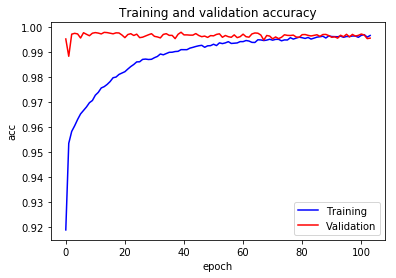

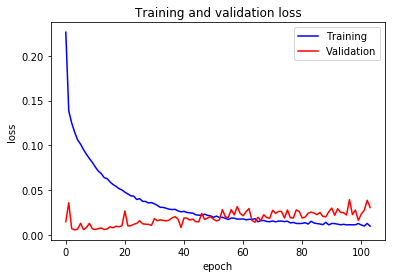

In [0]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()

In [0]:
from sklearn.metrics import average_precision_score,precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
from tensorflow.keras.models import load_model

In [0]:
path = 'e-res/best_model.hdf5'
criticality_network_load = load_model(path) #<----- The Model

In [0]:
score = criticality_network_load.evaluate(corpora_test_x, target_test_y, verbose=1)

11542/11542 [==============================] - 4s 354us/sample - loss: 0.0272 - accuracy: 0.9936


In [0]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027205977374802823
Test accuracy: 0.9935886


In [0]:
history_predict = criticality_network_load.predict(x=corpora_test_x)
history_predict

array([[1.0000000e+00, 2.3389704e-18],
       [3.0761971e-10, 1.0000000e+00],
       [1.0000000e+00, 4.9040064e-17],
       ...,
       [2.7979095e-07, 9.9999976e-01],
       [1.0000000e+00, 6.4942689e-19],
       [5.9354993e-10, 1.0000000e+00]], dtype=float32)

In [0]:
inferred_data = pd.DataFrame(history_predict,columns=list('AB'))
target_data = pd.DataFrame(target_test_y,columns=list('LN'))
data = target_data.join(inferred_data)

In [0]:
y_true = list(data['L'])
y_score= list(data['A'])
average_precision = average_precision_score(y_true, y_score)

In [0]:
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


In [0]:
#ROC Curve (all our samples are balanced)
auc = roc_auc_score(y_true, y_score)
print('AUC: %.3f' % auc)

AUC: 0.999
